# poor/rich neighborhoods and social ties
(sandorjuhasz & kovacsa shared notebook)

In [13]:
#import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import seaborn as sns
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
%matplotlib inline

import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon, LineString

import json
import time
import itertools
from copy import deepcopy

## Fig1 - home location / network / income

In [6]:
## location timelines

# tweets of the top 20 posters from Boston in our dataset
tweets = pd.read_csv('../data/illustration_boston_frequent_tweeters.csv',usecols=[0,1,2,3,4,5],header=None)
tweets.columns = ['user_id','run_id','tweet_id','lat','lon','text']
tweets['user_id'] = tweets['user_id'].map(int)

# timeline data of the top 20 posters in Boston in our dataset
hours = pd.read_csv('../data/illustration_boston_frequent_tweeters_timelines.csv',header=None)
hours.columns = ['user_id','cluster_id','weekday','hour','cnt']

In [8]:
# the 20 selected user_ids
user_ids = tweets['user_id'].unique()

# selecting one user -- manually until it hist looks fine
user_id = user_ids[5]

# cluster tweeting activity profiles
weekday_profiles = {}

plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = 10,7

# for all three clusters
for c in range(3):
    # get the weekday hourly tweetcounts
    hmask = (hours['user_id'] == user_id) & (hours['cluster_id'] == c)
    w = hours[hmask].pivot_table(index='weekday',columns='hour',values='cnt').fillna(0).loc[1:6].sum()
    # normalize (to be able to compare the 5000 tweets to the 200 tweets)
    w = w / w.sum()
    # fill up the missing hours
    w2 = np.zeros(24)
    w2[w.index] = w
    
    # creating x,y series for "rectangular" plotting
    x=[]
    y=[]
    for i,elem in enumerate(w2):
        if i==0:
            x.append(i)
            y.append(elem)
            x.append(i+0.5)
            y.append(elem)
        else:
            x.append(i-0.5)
            y.append(elem)
            x.append(i+0.5)
            y.append(elem)
    x.append(23.5)
    y.append(w2[0])            
    x.append(24)
    y.append(w2[0])
    
    # store activity profiles with cluster_id key to dict
    weekday_profiles[c] = x,y

In [10]:
## map data

# follower network -- data
edgelist = pd.read_csv('../data/usageousers_city_follower_networks.rpt.gz')
edgelist = edgelist.loc[edgelist['cbsacode'] == 14460.0]  # Boston only
# edgelist = edgelist.loc[edgelist['cbsacode'] == 35620.0]  # New York

# read in data about individuals -- data2
userinfo = pd.read_csv('../data/usageousers_data_export_with_tract_geoid_top50.csv.gz', index_col=0)
user_geo = userinfo.loc[:,["user_id", "lat_home", "lon_home", "lat_work", "lon_work"]]


# edgelist with geoinfo
edgelist = pd.merge(pd.merge(edgelist, user_geo, left_on="user_id1", right_on="user_id", how="left"),\
               user_geo, left_on="user_id2", right_on="user_id", how="left", suffixes=("1", "2"))

# remove duplicate columns
edgelist = edgelist.loc[:,~edgelist.columns.duplicated()]

In [11]:
# census data IN
census = pd.read_csv('../data/censusdata_top50_2012.csv')

# function to create tract geoids
def create_geoid(row):
    state = str(int(row["state"])).zfill(2)
    county = str(int(row["county"])).zfill(3)
    tract = str(int(row["tract"])).zfill(6)
    return "14000US" +state+county+tract

census['geoid'] = census.apply(create_geoid, axis=1)

# keep income ONLY
census = census.loc[:,["geoid", "income"]]

## add cbsacodes to census tract level dataframe
temp = userinfo.loc[:,['cbsacode', 'tract_home']].drop_duplicates()

# merge cbsacodes
census = pd.merge(census, temp, left_on="geoid", right_on="tract_home", how="left")
census = census.drop(columns=("tract_home"))

# further filters
census = census[(census['income'] > 0)]

# remove NAs...
census = census.dropna()
census.shape


# median income by cbsacode
census['income_median'] = census['cbsacode'].map(census.groupby('cbsacode')['income'].median().to_dict())
lo = (census['income'] < census["income_median"])
census['low'] = lo.astype(int).fillna(0)

# geojson data, converted to geopandas dataframe
tract_geoms = gpd.GeoDataFrame.from_features(
    [json.loads(e.strip('\n')) for e in open('../data/censustract_geoms_top50.geojson').readlines()]
)

# projections
init_crs = 4326 # lon,lat
project_crs = 3857 # Cartesian systems

# possibly projecting census tract geometries into the same Cartesian coordinate system as the user coordinates would work like
tract_geoms.crs = {'init': 'epsg:' + str(init_crs)}
tract_geoms.to_crs(epsg = init_crs, inplace=True)

# creating spatial index
tract_si = tract_geoms.sindex

# merge
tract_geoms = pd.merge(tract_geoms, census, left_on='full_geoid', right_on="geoid", how="left")

/usr/local/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [14]:
# focal user from high income area
focal_user = edgelist[edgelist["user_id1"]==6160022]
focal_user = focal_user[(focal_user["lat_home2"]>42.2) & (focal_user["lat_home2"]<42.45)]

# point of home
point_home = focal_user[['lon_home1', 'lat_home1']].drop_duplicates()
point_home['focal_home'] = point_home.apply(lambda row: Point(row['lon_home1'], row['lat_home1']), axis = 1)
point_home = point_home.set_geometry('focal_home')

# projection change
point_home.crs = {'init': 'epsg:4326'}

# create geodataframe with lines = edges between home locations
lines_home = deepcopy(focal_user)
lines_home['geometry_home_edges'] = lines_home.apply(lambda row: LineString([(row['lon_home1'], row['lat_home1']), (row['lon_home2'], row['lat_home2'])]),axis = 1)
lines_home = gpd.GeoDataFrame(lines_home).set_geometry('geometry_home_edges')

# projection change
lines_home.crs = {'init': 'epsg:4326'}

# point of friends
friend_homes = lines_home[['lon_home2', 'lat_home2']]
friend_homes['geometry_friend_home'] = friend_homes.apply(lambda row: Point(row['lon_home2'], row['lat_home2']), axis = 1)
friend_homes = friend_homes.set_geometry('geometry_friend_home')

# projection change
friend_homes.crs = {'init': 'epsg:4326'}

# list of friends
friends = set(list(focal_user['user_id2']))

# third ties
friend_table = edgelist[(edgelist['user_id1'].isin(friends)) & (edgelist['user_id2'].isin(friends))]
friend_table['geometry_third'] = friend_table.apply(lambda row: LineString([(row['lon_home1'], row['lat_home1']), (row['lon_home2'], row['lat_home2'])]),axis = 1)
friend_table = gpd.GeoDataFrame(friend_table).set_geometry('geometry_third')

# projection change
friend_table.crs = {'init': 'epsg:4326'}

/usr/local/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
<ipython-input-14-8c7c568fb541>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  friend_homes['geometry_friend_home'] = friend_homes.apply(lambda row: Point(row['lon_home2'], row['lat_home2']), axis = 1)
<ipython-input-14-8c7c568fb541>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [15]:
# keep only Boston census tracts
boston_bbox = {"lonmin":-71.55,"latmin":42.1,"lonmax":-70.9,"latmax":42.55}
boston_bbox_poly = Polygon([[boston_bbox["lonmin"],boston_bbox["latmin"]],
                   [boston_bbox["lonmax"],boston_bbox["latmin"]],
                   [boston_bbox["lonmax"],boston_bbox["latmax"]],
                   [boston_bbox["lonmin"],boston_bbox["latmax"]]])
boston_geoms = tract_geoms[tract_geoms.geometry.within(boston_bbox_poly)] #.to_crs({'init' : 'epsg:4326'})

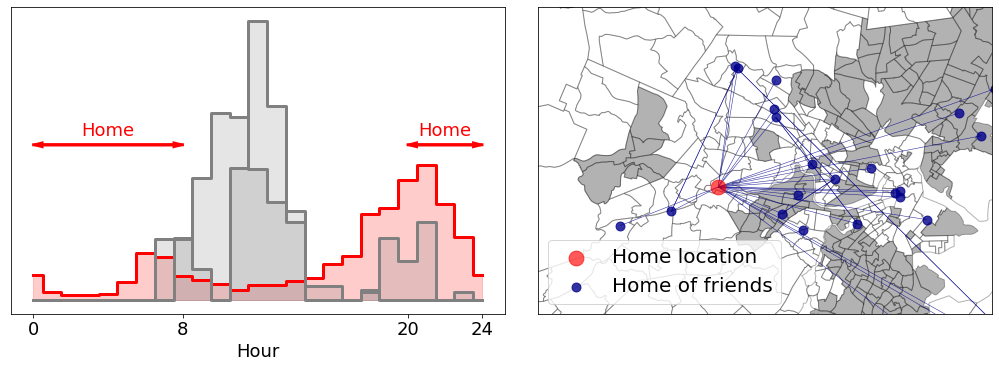

In [25]:
# Fig1 plot
fig, ax = plt.subplots(1, 2, figsize = (14, 5), constrained_layout=True)
plt.rcParams['font.size']=18

# timeline histograms
for c,hatch,color in zip([0,1,2],['x','o','//'],["red","grey","grey"]):
    ax[0].plot(*weekday_profiles[c], color=color, lw=3)
    ax[0].fill_between(*weekday_profiles[c],color=color, label=r'Location '+str(c+1)+' timeline', alpha=0.2)
# Timeline of home location / Timeline of other locations
# ax.legend(ncol=1,frameon=False,loc=9,bbox_to_anchor=(0.5,1.15))
ax[0].set_xlabel('Hour')


# home delimiters
ax[0].xaxis.set_ticks([0,8,20,24])
ax[0].yaxis.set_ticks([])

# mark home time span
ax[0].arrow(0,0.16,8,0,lw=2,color='red', head_length = 0.5, head_width = 0.005, length_includes_head = True)
ax[0].arrow(8,0.16,-8,0,lw=2,color='red', head_length = 0.5, head_width = 0.005, length_includes_head = True)
ax[0].annotate('Home',(4,0.175),color='red',ha='center',va='center')

ax[0].arrow(20,0.16,4,0,lw=2,color='red', head_length = 0.5, head_width = 0.005, length_includes_head = True)
ax[0].arrow(24,0.16,-4,0,lw=2,color='red', head_length = 0.5, head_width = 0.005, length_includes_head = True)
ax[0].annotate('Home',(22,0.175),color='red',ha='center',va='center')



# map
boston_geoms.plot(ax=ax[1], column = 'low', cmap='Greys', edgecolor = 'black', alpha=0.3)

# home point
point_home.plot(ax=ax[1], color='red', marker='o', markersize=220, alpha=0.65, zorder=3, label = 'Home location')

# edges
lines_home.plot(ax=ax[1], alpha=0.8, color='darkblue', linewidth=0.55)
friend_table.plot(ax=ax[1], alpha=0.8, color='darkblue', linewidth=0.55)

# homes of friends
friend_homes.plot(ax=ax[1], color='darkblue', markersize=80, alpha=0.8, label = 'Home of friends')
 
# zoom in
# ax[0].set_xlim(min(friend_homes['lon_home2'])-0.025, max(friend_homes['lon_home2'])+0.025)
# ax[0].set_ylim(min(friend_homes['lat_home2'])-0.025, max(friend_homes['lat_home2'])+0.025)
ax[1].set_xlim(-71.3, -71.00)
ax[1].set_ylim(42.3, 42.45)
# ax[0].set_title("From HIGH icome area", size=18)

# legend
ax[1].legend(loc='lower left', fontsize=20, frameon=True)

#ax[1].set_axis_off()
ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])



plt.show()

## Fig2 - concentration of ties

In [2]:
# reopen degree_tab
degree_tab = pd.read_csv("../data/degree_tab_top50.csv.gz")

In [3]:
# data for Fig2a
pr = {"poor" : 1, "rich" : 0}

rownames = []
means = []
type = list(["poor"] *20) + list(["rich"] *20)

# loop to construct the dataframe
for t in pr:
 
    # name the necessary columns
    col_filter = ['dcum500_share','dcum1000_share', 'dcum1500_share','dcum2000_share', 'dcum2500_share', 'dcum3000_share', 'dcum3500_share', 'dcum4000_share',  'dcum4500_share', 'dcum5000_share', 'dcum5500_share','dcum6000_share', 'dcum6500_share', 'dcum7000_share', 'dcum7500_share', 'dcum8000_share', 'dcum8500_share', 'dcum9000_share', 'dcum9500_share', 'dcum10000_share']

    # table and columns to use
    temp = degree_tab[degree_tab["poor"]==pr[t]]
    temp = temp.loc[:, temp.columns.isin(col_filter)]

    # loop for variables
    for c in list(temp.columns):
        rownames.append(str(c))
        means.append(np.mean(temp[str(c)]))

fig_a = pd.DataFrame({ 'dist': rownames , 'mean': means, 'type': type})

In [4]:
# data for Fig2b

# add new columns
col_list = ["d500", "d1000", "d1500", "d2000", "d2500", "d3000", "d3500", "d4000", "d4500", "d5000", "d5500", "d6000", "d6500", "d7000", "d7500", "d8000", "d8500", "d9000", "d9500", "d10000"]

# share of ties at distance
for c in list(col_list):
    degree_tab[str(c) + "_share"] = degree_tab[str(c)] / degree_tab["degree"]

# replace NA with 0
degree_tab = degree_tab.fillna(0)

# poor-rich means
pr = {"poor" : 1, "rich" : 0}

rownames = []
means = []
type = list(["poor"] *20) + list(["rich"] *20)

# loop to construct the dataframe
for t in pr:
    
    # name the necessary columns
    col_filter = ['d500_share','d1000_share', 'd1500_share','d2000_share', 'd2500_share','d3000_share', 'd3500_share','d4000_share',  'd4500_share', 'd5000_share', 'd5500_share','d6000_share', 'd6500_share', 'd7000_share', 'd7500_share', 'd8000_share', 'd8500_share', 'd9000_share', 'd9500_share', 'd10000_share']

    # table and columns to use
    temp = degree_tab[degree_tab["poor"]==pr[t]]
    temp = temp.loc[:, temp.columns.isin(col_filter)]

    # loop for variables
    for c in list(temp.columns):
        rownames.append(str(c))
        means.append(np.mean(temp[str(c)]))

fig_b = pd.DataFrame({ 'dist': rownames , 'mean': means, 'type': type})

In [5]:
# data for Fig2c

rownames = []
means = []
type = list(["poor"] *20) + list(["rich"] *20)

# name the necessary columns
col_filter = ['d500','d1000', 'd1500','d2000', 'd2500','d3000', 'd3500','d4000',  'd4500', 'd5000',
    'd5500','d6000', 'd6500', 'd7000', 'd7500', 'd8000', 'd8500', 'd9000', 'd9500', 'd10000']

# loop to construct the dataframe
for t in pr:
    
    # table and columns to use
    temp = degree_tab[degree_tab["poor"]==pr[t]]
    temp = temp.loc[:, temp.columns.isin(col_filter)]

    # multiplicator - to get the additional area of concentric circles/rings (r2*pi -- 1,4,9,16..)
    x = np.linspace(1,39,20)

    # loop for variables
    for idx, c in enumerate(list(temp.columns)):
        rownames.append(str(c))
        means.append((np.mean(temp[str(c)]) * 1/x[idx]) * 1/(0.25*np.pi))   # area of the circle defined in the baseline 0.5*0.5*pi area
        
fig_c = pd.DataFrame({ 'dist': rownames , 'mean': means, 'type': type})

<ipython-input-30-1a5eb4030044>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
<ipython-input-30-1a5eb4030044>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)
<ipython-input-30-1a5eb4030044>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(labels)
<ipython-input-30-1a5eb4030044>:63: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/mf2.png',density=300,bbox_inches='tight')


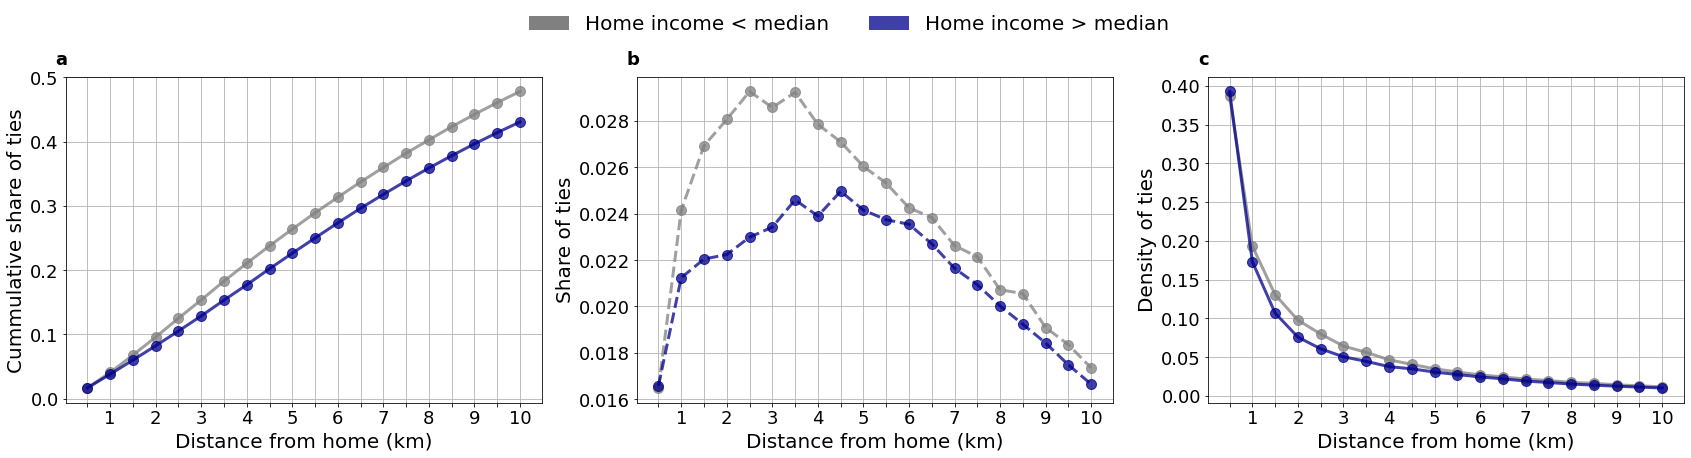

In [30]:
# plot 2
fig,ax = plt.subplots(1,3,figsize=(29,6), sharex=True)
plt.rcParams['font.size']=18

labels = list((np.linspace(0.5,10,20)).astype(int))



## plot A
ax[0].plot(fig_a["dist"][:20], fig_a[fig_a["type"]=="poor"]["mean"], "o-", color="grey", linewidth=3, markersize=10, alpha=0.75)
ax[0].plot(fig_a["dist"][20:], fig_a[fig_a["type"]=="rich"]["mean"], "o-", color="darkblue", linewidth=3, markersize=10, alpha=0.75)
ax[0].set_xticklabels(labels)
for label in ax[0].get_xticklabels()[::2]:
    label.set_visible(False)

ax[0].set_xlabel("Distance from home (km)", size=20)
ax[0].set_ylabel("Cummulative share of ties",  size=20)
ax[0].grid()



## plot B
ax[1].plot(fig_b["dist"][:20], fig_b[fig_b["type"]=="poor"]["mean"], "o--", color="grey", linewidth=3, markersize=10, alpha=0.75)
ax[1].plot(fig_b["dist"][20:], fig_b[fig_b["type"]=="rich"]["mean"], "o--", color="darkblue", linewidth=3, markersize=10, alpha=0.75)
ax[1].set_xticklabels(labels)
for label in ax[1].get_xticklabels()[::2]:
    label.set_visible(False)

ax[1].set_xlabel("Distance from home (km)", size=20)
ax[1].set_ylabel("Share of ties",  size=20)
ax[1].grid()



## plot C
ax[2].plot(fig_c["dist"][:20], fig_c[fig_c["type"]=="poor"]["mean"], "o-", color="grey", linewidth=3, markersize=10, alpha=0.75)
ax[2].plot(fig_c["dist"][20:], fig_c[fig_c["type"]=="rich"]["mean"], "o-", color="darkblue", linewidth=3, markersize=10, alpha=0.75)
ax[2].set_xticklabels(labels)
for label in ax[2].get_xticklabels()[::2]:
    label.set_visible(False)

ax[2].set_xlabel("Distance from home (km)", size=20)
ax[2].set_ylabel("Density of ties",  size=20)
#ax[2].semilogy()
ax[2].grid()

#home_patch = mpatches.Patch(color='grey', label='Home income < median', alpha=0.75)
#work_patch = mpatches.Patch(color='darkblue', label='Home income > median', alpha=0.75)
#ax.legend(handles=[home_patch, work_patch])

# legend
custom_lines = [Patch(facecolor='grey'), Patch(facecolor='darkblue', alpha=0.75)]
labels = [ 'Home income < median', 'Home income > median']

plt.figlegend(custom_lines, labels, loc='upper center',
    bbox_to_anchor=(0.5, 1.065),
    ncol=2, frameon=False, fontsize=20)

# subplot title
for a, label in zip(ax, ['A','B','C','D','E','F','G','H']):
    a.annotate(label.lower(), xy=(0,1), xycoords='axes fraction', xytext=(-10,12.5),textcoords='offset pixels', weight='bold')

# plt.savefig('../fig/mf2.png',density=300,bbox_inches='tight')
plt.show()

<ipython-input-158-8cba105cd6f1>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


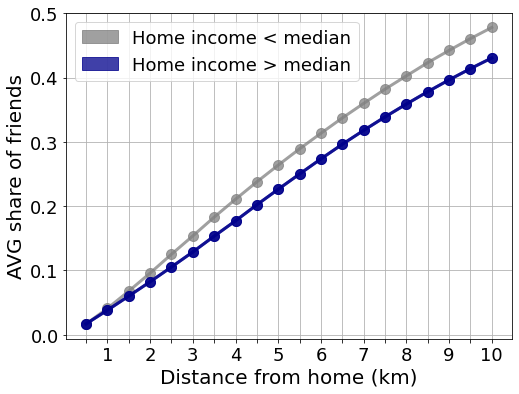

In [158]:
# plot 2
fig,ax = plt.subplots(1,1,figsize=(8,6), sharey=True)
plt.rcParams['font.size']=18

labels = list((np.linspace(0.5,10,20)).astype(int))

home_poor = ax.plot(fig_a["dist"][:20], fig_a[fig_a["type"]=="poor"]["mean"], "o-", color="grey", linewidth=3, markersize=10, alpha=0.75)
home_rich = ax.plot(fig_a["dist"][20:], fig_a[fig_a["type"]=="rich"]["mean"], "o-", color="darkblue", linewidth=3, markersize=10, alpha=0.75)
ax.plot(fig_a["dist"][20:], fig_a[fig_a["type"]=="rich"]["mean"], "o-", color="darkblue", linewidth=3, markersize=10, alpha=0.75)
ax.set_xticklabels(labels)
for label in ax.get_xticklabels()[::2]:
    label.set_visible(False)

home_patch = mpatches.Patch(color='grey', label='Home income < median', alpha=0.75)
work_patch = mpatches.Patch(color='darkblue', label='Home income > median', alpha=0.75)
ax.legend(handles=[home_patch, work_patch])

ax.set_xlabel("Distance from home (km)", size=20)
ax.set_ylabel("AVG share of friends",  size=20)
ax.grid()

plt.show()

In [126]:
# data for Fig2b

# add new columns
col_list = ["d500", "d1000", "d1500", "d2000", "d2500", "d3000", "d3500", "d4000", "d4500", "d5000", "d5500", "d6000", "d6500", "d7000", "d7500", "d8000", "d8500", "d9000", "d9500", "d10000"]

# share of ties at distance
for c in list(col_list):
    degree_tab[str(c) + "_share"] = degree_tab[str(c)] / degree_tab["degree"]

# replace NA with 0
degree_tab = degree_tab.fillna(0)

# poor-rich means
pr = {"poor" : 1, "rich" : 0}

rownames = []
means = []
type = list(["poor"] *20) + list(["rich"] *20)

# loop to construct the dataframe
for t in pr:
    
    # name the necessary columns
    col_filter = ['d500_share','d1000_share', 'd1500_share','d2000_share', 'd2500_share','d3000_share', 'd3500_share','d4000_share',  'd4500_share', 'd5000_share', 'd5500_share','d6000_share', 'd6500_share', 'd7000_share', 'd7500_share', 'd8000_share', 'd8500_share', 'd9000_share', 'd9500_share', 'd10000_share']

    # table and columns to use
    temp = degree_tab[degree_tab["poor"]==pr[t]]
    temp = temp.loc[:, temp.columns.isin(col_filter)]

    # loop for variables
    for c in list(temp.columns):
        rownames.append(str(c))
        means.append(np.mean(temp[str(c)]))

fig_b = pd.DataFrame({ 'dist': rownames , 'mean': means, 'type': type})

<ipython-input-132-29b177443f9b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


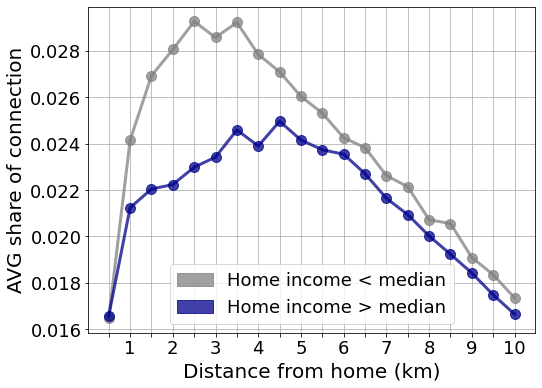

In [132]:
# parameters of chart
fig,ax = plt.subplots(1,1,figsize=(8,6), sharey=True)
plt.rcParams['font.size']=18

labels = list((np.linspace(0.5,10,20)).astype(int))

home_poor = ax.plot(fig_b["dist"][:20], fig_b[fig_b["type"]=="poor"]["mean"], "o-", color="grey", linewidth=3, markersize=10, alpha=0.75)
home_rich = ax.plot(fig_b["dist"][20:], fig_b[fig_b["type"]=="rich"]["mean"], "o-", color="darkblue", linewidth=3, markersize=10, alpha=0.75)
ax.set_xticklabels(labels)
for label in ax.get_xticklabels()[::2]:
    label.set_visible(False)

home_patch = mpatches.Patch(color='grey', label='Home income < median', alpha=0.75)
work_patch = mpatches.Patch(color='darkblue', label='Home income > median', alpha=0.75)
ax.legend(handles=[home_patch, work_patch])

ax.set_xlabel("Distance from home (km)", size=20)
ax.set_ylabel("AVG share of connection",  size=20)
ax.grid()

plt.show()

In [206]:
# data for Fig2c

rownames = []
means = []
type = list(["poor"] *20) + list(["rich"] *20)

# name the necessary columns
col_filter = ['d500','d1000', 'd1500','d2000', 'd2500','d3000', 'd3500','d4000',  'd4500', 'd5000',
    'd5500','d6000', 'd6500', 'd7000', 'd7500', 'd8000', 'd8500', 'd9000', 'd9500', 'd10000']

# loop to construct the dataframe
for t in pr:
    
    # table and columns to use
    temp = degree_tab[degree_tab["poor"]==pr[t]]
    temp = temp.loc[:, temp.columns.isin(col_filter)]

    # multiplicator - to get the additional area of concentric circles/rings (r2*pi -- 1,4,9,16..)
    x = np.linspace(1,39,20)

    # loop for variables
    for idx, c in enumerate(list(temp.columns)):
        rownames.append(str(c))
        means.append((np.mean(temp[str(c)]) * 1/x[idx]) * 1/(0.25*np.pi))   # area of the circle defined in the baseline 0.5*0.5*pi area
        
fig_c = pd.DataFrame({ 'dist': rownames , 'mean': means, 'type': type})

<ipython-input-207-4bb4bd15c2e0>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


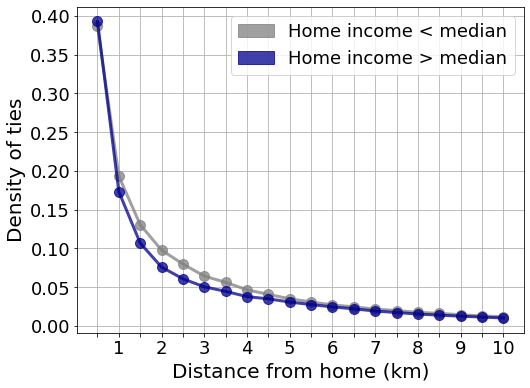

In [207]:
# 
fig,ax = plt.subplots(1,1,figsize=(8,6), sharey=True)
plt.rcParams['font.size']=18

labels = list((np.linspace(0.5,10,20)).astype(int))

home_poor = ax.plot(fig_c["dist"][:20], fig_c[fig_c["type"]=="poor"]["mean"], "o-", color="grey", linewidth=3, markersize=10, alpha=0.75)
home_rich = ax.plot(fig_c["dist"][20:], fig_c[fig_c["type"]=="rich"]["mean"], "o-", color="darkblue", linewidth=3, markersize=10, alpha=0.75)
ax.set_xticklabels(labels)
for label in ax.get_xticklabels()[::2]:
    label.set_visible(False)

home_patch = mpatches.Patch(color='grey', label='Home income < median', alpha=0.75)
work_patch = mpatches.Patch(color='darkblue', label='Home income > median', alpha=0.75)
ax.legend(handles=[home_patch, work_patch])

ax.set_xlabel("Distance from home (km)", size=20)
ax.set_ylabel("Density of ties",  size=20)
ax.grid()

plt.show()

In [201]:
degree_tab.columns

Index(['user_id', 'cbsacode', 'short_name', 'poor', 'lat_home', 'lon_home',
       'degree', 'd500', 'd1000', 'd1500', 'd2000', 'd2500', 'd3000', 'd3500',
       'd4000', 'd4500', 'd5000', 'd5500', 'd6000', 'd6500', 'd7000', 'd7500',
       'd8000', 'd8500', 'd9000', 'd9500', 'd10000', 'dcum500', 'dcum1000',
       'dcum1500', 'dcum2000', 'dcum2500', 'dcum3000', 'dcum3500', 'dcum4000',
       'dcum4500', 'dcum5000', 'dcum5500', 'dcum6000', 'dcum6500', 'dcum7000',
       'dcum7500', 'dcum8000', 'dcum8500', 'dcum9000', 'dcum9500', 'dcum10000',
       'dcum500_share', 'dcum1000_share', 'dcum1500_share', 'dcum2000_share',
       'dcum2500_share', 'dcum3000_share', 'dcum3500_share', 'dcum4000_share',
       'dcum4500_share', 'dcum5000_share', 'dcum5500_share', 'dcum6000_share',
       'dcum6500_share', 'dcum7000_share', 'dcum7500_share', 'dcum8000_share',
       'dcum8500_share', 'dcum9000_share', 'dcum9500_share',
       'dcum10000_share'],
      dtype='object')

In [ ]:
# create poor / rich groups
degree_rich = degree_tab[degree_tab['poor'] == 0]
degree_poor = degree_tab[degree_tab['poor'] == 1]

Bootstrapping via https://towardsdatascience.com/calculating-confidence-interval-with-bootstrapping-872c657c058d

In [4]:
# bootstrap function
def draw_bs_replicates(data, func, size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # create an empty array to store replicates
    bs_replicates = np.empty(size)
    np.random.seed(30)
    # create bootstrap replicates as much as size
    for i in range(size):
        # create a bootstrap sample
        bs_sample = np.random.choice(data, size=len(data))
        # get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

## plot 1 --- density of ties around home poor/rich

In [10]:
# construct a dataframe -rich- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# name the necessary columns
col_filter = ['d500','d1000', 'd1500','d2000', 'd2500','d3000', 'd3500','d4000',  'd4500', 'd5000',
    'd5500','d6000', 'd6500', 'd7000', 'd7500', 'd8000', 'd8500', 'd9000', 'd9500', 'd10000']

# annotations
annotations = ['0.5','1', '1.5','2','2.5','3','3.5','4', '4.5', '5', '5.5','6','6.5', '7','7.5','8','8.5','9','9.5', '10']

# type plot
type = ["rich"] * 20

# multiplicator - to get the additional area of concentric circles/rings (r2*pi -- 1,4,9,16.. -- 1,3,5,7...)
x = np.concatenate([np.linspace(1,39,20),np.linspace(1,39,20)])

# table and columns to use
temp = degree_rich.loc[:, degree_rich.columns.isin(col_filter)]

# loop for variables
for idx, c in enumerate(list(temp.columns)):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)], np.mean, 2000) # bootstrap
    area_mean = (bootstrap_mean * 1/x[idx]) * 1/(0.25*np.pi)   # area of the circle defined in the baseline 0.5*0.5*pi area
    means.append(np.mean(area_mean))
    lower.append(np.percentile(area_mean, 2.5))
    upper.append(np.percentile(area_mean, 97.5))
    error_lower.append((np.mean(area_mean) - np.percentile(area_mean, 2.5)))
    error_upper.append((np.percentile(area_mean, 97.5) - np.mean(area_mean)))
    
result_rich = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type, 'distance': annotations})

In [11]:
# construct a dataframe -poor- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# name the necessary columns
col_filter = ['d500','d1000', 'd1500','d2000', 'd2500','d3000', 'd3500','d4000',  'd4500', 'd5000',
    'd5500','d6000', 'd6500', 'd7000', 'd7500', 'd8000', 'd8500', 'd9000', 'd9500', 'd10000']

# annotations
annotations = ['0.5','1', '1.5','2','2.5','3','3.5','4', '4.5', '5', '5.5','6','6.5', '7','7.5','8','8.5','9','9.5', '10']

# type plot
type = ["poor"] * 20

# multiplicator - to get the additional area of concentric circles/rings (r2*pi -- 1,4,9,16.. -- 1,3,5,7...)
x = np.concatenate([np.linspace(1,39,20),np.linspace(1,39,20)])

# table and columns to use
temp = degree_poor.loc[:, degree_poor.columns.isin(col_filter)]

# loop for variables
for idx, c in enumerate(list(temp.columns)):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)], np.mean, 2000) # bootstrap
    area_mean = (bootstrap_mean * 1/x[idx]) * 1/(0.25*np.pi)   # area of the circle defined in the baseline 0.5*0.5*pi area
    means.append(np.mean(area_mean))
    lower.append(np.percentile(area_mean, 2.5))
    upper.append(np.percentile(area_mean, 97.5))
    error_lower.append((np.mean(area_mean) - np.percentile(area_mean, 2.5)))
    error_upper.append((np.percentile(area_mean, 97.5) - np.mean(area_mean)))
    
result_poor = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type, 'distance': annotations})

In [23]:
# combine
plotdata = pd.concat([result_poor, result_rich])

<ipython-input-29-e9b907e576b9>:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/fig1.png',density=300,bbox_inches='tight')


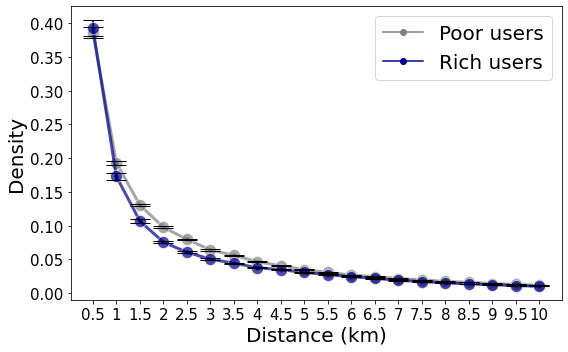

In [29]:
# parameters of chart
fig, ax = plt.subplots(1,1, figsize=(8, 5))

# colors of lines
colorsList = ["grey", "darkblue"]

# lineplots created
sns.lineplot(data = plotdata, x = 'distance', y = 'mean', hue = 'type', style = 'type', palette = colorsList, ax = ax, markers=["o", "o"], markersize = 12, dashes = False, linewidth = 3, alpha=0.7)

# add errorbars
ax.errorbar(data = plotdata, x = 'distance', y = 'mean', yerr= [plotdata['error_lower'], plotdata['error_upper']], linestyle='', fmt = '.k', barsabove = True, capsize = 10)

# customize labels and legends
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[1:], labels=['Poor users', 'Rich users'], fontsize = 20, edgecolor = 'black')
ax.legend(handles=handles[0:], labels=['Poor users', 'Rich users'], fontsize = 20)
ax.set(xlabel='Distance (km)', ylabel='Density')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis='both', which='major', labelsize=15)
# ax.tick_params(axis = 'x',rotation = 45)

plt.tight_layout()
# plt.savefig('../fig/fig1.png',density=300,bbox_inches='tight')

## cumulative share of friends around home by income level

In [30]:
# reopen degree_tab
degree_tab = pd.read_csv("../data/degree_tab_top50.csv.gz")

# create poor / rich groups
degree_rich = degree_tab[degree_tab['poor'] == 0]
degree_poor = degree_tab[degree_tab['poor'] == 1]

In [31]:
# bootstrap function
def draw_bs_replicates(data, func, size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # create an empty array to store replicates
    bs_replicates = np.empty(size)
    np.random.seed(30)
    # create bootstrap replicates as much as size
    for i in range(size):
        # create a bootstrap sample
        bs_sample = np.random.choice(data, size=len(data))
        # get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

In [32]:
# construct a dataframe -poor- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# name the necessary columns
col_filter = ['dcum500_share','dcum1000_share', 'dcum1500_share','dcum2000_share', 'dcum2500_share','dcum3000_share', 'dcum3500_share','dcum4000_share',  'dcum4500_share', 'dcum5000_share',
    'dcum5500_share','dcum6000_share', 'dcum6500_share', 'dcum7000_share', 'dcum7500_share', 'dcum8000_share', 'dcum8500_share', 'dcum9000_share', 'dcum9500_share', 'dcum10000_share']

# annotations
annotations = np.linspace(0.5,10,20)

# type plot
type = ["poor"] * 20

# table and columns to use
temp = degree_poor.loc[:, degree_poor.columns.isin(col_filter)]

# loop for variables
for c in list(temp.columns):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)], np.mean, 2000)   # change repetition HERE
    means.append(np.mean(bootstrap_mean))
    lower.append(np.percentile(bootstrap_mean, 2.5))
    upper.append(np.percentile(bootstrap_mean, 97.5))
    error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
    error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_poor = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type, 'distance': annotations})

In [33]:
# construct a dataframe -rich- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# name the necessary columns
col_filter = ['dcum500_share','dcum1000_share', 'dcum1500_share','dcum2000_share', 'dcum2500_share','dcum3000_share', 'dcum3500_share','dcum4000_share',  'dcum4500_share', 'dcum5000_share',
    'dcum5500_share','dcum6000_share', 'dcum6500_share', 'dcum7000_share', 'dcum7500_share', 'dcum8000_share', 'dcum8500_share', 'dcum9000_share', 'dcum9500_share', 'dcum10000_share']

# annotations
annotations = np.linspace(0.5,10,20)

# type plot
type = ["rich"] * 20

# table and columns to use
temp = degree_rich.loc[:, degree_rich.columns.isin(col_filter)]

# loop for variables
for c in list(temp.columns):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)], np.mean, 2000)   # change repetition HERE
    means.append(np.mean(bootstrap_mean))
    lower.append(np.percentile(bootstrap_mean, 2.5))
    upper.append(np.percentile(bootstrap_mean, 97.5))
    error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
    error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_rich = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type, 'distance': annotations})

In [35]:
# combine
plotdata = pd.concat([result_poor, result_rich])

<ipython-input-39-972885c012e1>:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/fig2.png',density=300,bbox_inches='tight')


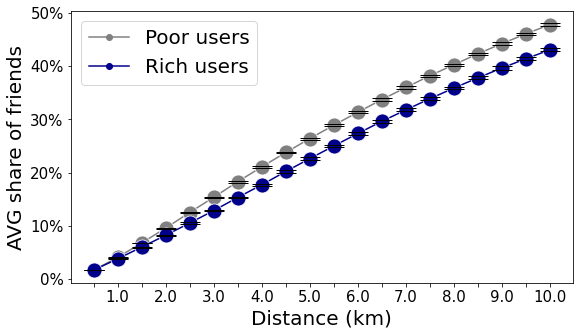

In [39]:
# parameters of chart
fig, ax = plt.subplots(1,1, figsize=(9,5))

# colors of lines
colorsList = ["grey", "darkblue"]

# lineplot created
ax = sns.lineplot(data = plotdata, x = 'distance', y = 'mean', hue = 'type', style = 'type', palette = colorsList, dashes=False, ax = ax, markers=["o", "o"], markersize = 15)

ax.errorbar(data = plotdata, x = 'distance', y = 'mean', yerr= [plotdata['error_lower'], plotdata['error_upper']], linestyle='', fmt = '.k', barsabove = True, capsize = 10)

# customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Poor users', 'Rich users'], fontsize = 20)
ax.set(xlabel='Distance (km)', ylabel='AVG share of friends')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_major_locator(mtick.MultipleLocator(0.5))
# ax.set_title('Share of friends around home', size = 30)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

# plt.savefig('../fig/fig2.png',density=300,bbox_inches='tight')

## avg share 1/5/10 plots

In [40]:
# run the above part until plotdata

# means
poor_means = [result_poor["mean"][1], result_poor['mean'][9], result_poor['mean'][19]]
rich_means = [result_rich["mean"][1], result_rich['mean'][9], result_rich['mean'][19]]

# errors
poor_error_lower = [result_poor['error_lower'][1], result_poor['error_lower'][9], result_poor['error_lower'][19]]
poor_error_upper = [result_poor['error_upper'][1], result_poor['error_upper'][9], result_poor['error_upper'][19]]
rich_error_lower = [result_rich['error_lower'][1], result_rich['error_lower'][9], result_rich['error_lower'][19]]
rich_error_upper = [result_rich['error_upper'][1], result_rich['error_upper'][9], result_rich['error_upper'][19]]

<ipython-input-44-1c9850fad4e6>:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/fig3.png',density=300,bbox_inches='tight')


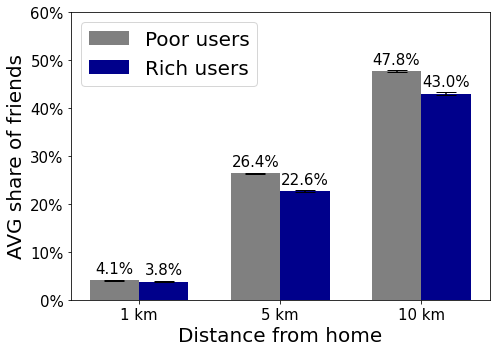

In [44]:
# parameters of chart
fig, ax = plt.subplots(1,1, figsize=(7, 5))

titles = ['1 km', '5 km', '10 km']
                                                                                                                    
# color of bars
colorsList = ["grey", "darkblue"]

# bars
X = np.arange(3)
bar_width = 0.35
rects1 = ax.bar(X, poor_means, color = colorsList[0], width = bar_width, label = 'Poor users', yerr = [poor_error_lower, poor_error_upper], capsize = 10)
rects2 = ax.bar(X + bar_width, rich_means, color = colorsList[1], width = bar_width, label = 'Rich users', yerr = [rich_error_lower, rich_error_upper], capsize = 10) 

# customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels=['Poor users', 'Rich users'], fontsize = 20, loc="upper left") # edgecolor = 'black'
ax.set(ylabel='AVG share of friends')
ax.set(xlabel='Distance from home')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0)) 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticks(X + bar_width/2)
ax.set_xticklabels(['1 km', '5 km', '10 km'])
ax.set_ylim([0, 0.6])

#function used for labelling
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate("{:.1%}".format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 15)
autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
# plt.savefig('../fig/fig3.png',density=300,bbox_inches='tight')

## change in share of friends

In [45]:
# reopen degree_tab
degree_tab = pd.read_csv("../data/degree_tab_top50.csv.gz")

In [46]:
# add new columns
col_list = ["d500", "d1000", "d1500", "d2000", "d2500", "d3000", "d3500", "d4000", "d4500", "d5000", "d5500", "d6000", "d6500", "d7000", "d7500", "d8000", "d8500", "d9000", "d9500", "d10000"]

for c in list(col_list):
    degree_tab[str(c) + "_share"] = degree_tab[str(c)] / degree_tab["degree"]

# replace NA with 0
degree_tab = degree_tab.fillna(0)

In [47]:
# create poor / rich groups
degree_rich = degree_tab[degree_tab['poor'] == 0]
degree_poor = degree_tab[degree_tab['poor'] == 1]

In [48]:
# bootstrap function
def draw_bs_replicates(data, func, size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # create an empty array to store replicates
    bs_replicates = np.empty(size)
    np.random.seed(30)
    # create bootstrap replicates as much as size
    for i in range(size):
        # create a bootstrap sample
        bs_sample = np.random.choice(data, size=len(data))
        # get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

In [49]:
# construct a dataframe -poor- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# name the necessary columns
col_filter = ['d500_share','d1000_share', 'd1500_share','d2000_share', 'd2500_share','d3000_share', 'd3500_share','d4000_share',  'd4500_share', 'd5000_share', 'd5500_share','d6000_share', 'd6500_share', 'd7000_share', 'd7500_share', 'd8000_share', 'd8500_share', 'd9000_share', 'd9500_share', 'd10000_share']

# type plot
type = ["poor"] * 20

# table and columns to use
temp = degree_poor.loc[:, degree_poor.columns.isin(col_filter)]

# loop for variables
for c in list(temp.columns):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)], np.mean, 2000)   # change repetition HERE
    means.append(np.mean(bootstrap_mean))
    lower.append(np.percentile(bootstrap_mean, 2.5))
    upper.append(np.percentile(bootstrap_mean, 97.5))
    error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
    error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_poor = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type, 'distance': annotations})

In [50]:
# construct a dataframe -poor- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# name the necessary columns
col_filter = ['d500_share','d1000_share', 'd1500_share','d2000_share', 'd2500_share','d3000_share', 'd3500_share','d4000_share',  'd4500_share', 'd5000_share', 'd5500_share','d6000_share', 'd6500_share', 'd7000_share', 'd7500_share', 'd8000_share', 'd8500_share', 'd9000_share', 'd9500_share', 'd10000_share']

# type plot
type = ["rich"] * 20

# table and columns to use
temp = degree_rich.loc[:, degree_rich.columns.isin(col_filter)]

# loop for variables
for c in list(temp.columns):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)], np.mean, 2000)   # change repetition HERE
    means.append(np.mean(bootstrap_mean))
    lower.append(np.percentile(bootstrap_mean, 2.5))
    upper.append(np.percentile(bootstrap_mean, 97.5))
    error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
    error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_rich = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type, 'distance': annotations})

In [53]:
# combine
plotdata = pd.concat([result_poor, result_rich])

<ipython-input-61-9548233e863b>:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/fig4.png',density=300,bbox_inches='tight')


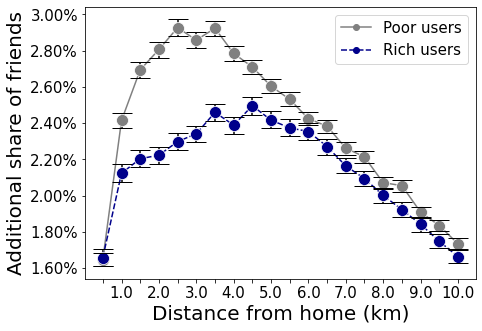

In [61]:
# parameters of chart
fig, ax = plt.subplots(1,1, figsize=(7, 5))

# colors of lines
colorsList = ["grey", "darkblue"]

# lineplot created
ax = sns.lineplot(data = plotdata, x = 'distance', y = 'mean', hue = 'type', style = 'type', palette = colorsList, dashes=True, ax = ax, markers=["o", "o"], markersize = 12)

ax.errorbar(data = plotdata, x = 'distance', y = 'mean', yerr= [plotdata['error_lower'], plotdata['error_upper']], linestyle='', fmt = '.k', barsabove = True, capsize = 10)

#customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=['Poor users', 'Rich users'], fontsize = 15)
ax.set(xlabel='Distance from home (km)', ylabel='Additional share of friends')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_major_locator(mtick.MultipleLocator(0.5))
# ax.set_title('$\Delta$ Share of friends around home', size = 30)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

plt.savefig('../fig/fig4.png',density=300,bbox_inches='tight')

## clustering around HOME

In [3]:
# clustering table
clust_table = pd.read_csv("../data/clust_tab_top50.csv.gz")

# poor / rich info
user_info = pd.read_csv("../data/degree_tab_top50.csv.gz")
user_info = user_info[["user_id", "cbsacode", "short_name", "poor"]]

In [4]:
# add poor / rich info
clust_table = pd.merge(clust_table, user_info, on="user_id", how="left")

In [5]:
# create poor / rich groups
clust_rich = clust_table[clust_table['poor'] == 0]
clust_poor = clust_table[clust_table['poor'] == 1]

In [6]:
# bootstrap function
def draw_bs_replicates(data, func, size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # create an empty array to store replicates
    bs_replicates = np.empty(size)
    np.random.seed(30)
    # create bootstrap replicates as much as size
    for i in range(size):
        # create a bootstrap sample
        bs_sample = np.random.choice(data, size=len(data))
        # get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

In [7]:
# construct a dataframe -poor- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# type plot
type = ["poor"] * 3

# name the necessary columns
col_filter = ['clust1000','clust5000', 'clust10000']

# table and columns to use
temp = clust_poor.loc[:, clust_poor.columns.isin(col_filter)]

# loop for variables
for c in list(temp.columns):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)].dropna(), np.mean, 2000)   # change repetition HERE
    means.append(np.mean(bootstrap_mean))
    lower.append(np.percentile(bootstrap_mean, 2.5))
    upper.append(np.percentile(bootstrap_mean, 97.5))
    error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
    error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_poor = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type})

In [8]:
# construct a dataframe -rich- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# type plot
type = ["rich"] * 3

# name the necessary columns
col_filter = ['clust1000','clust5000', 'clust10000']

# table and columns to use
temp = clust_rich.loc[:, clust_rich.columns.isin(col_filter)]

# loop for variables
for c in list(temp.columns):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)].dropna(), np.mean, 2000)   # change repetition HERE
    means.append(np.mean(bootstrap_mean))
    lower.append(np.percentile(bootstrap_mean, 2.5))
    upper.append(np.percentile(bootstrap_mean, 97.5))
    error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
    error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_rich = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type})

In [9]:
# combine
cluster_plot = pd.concat([result_poor, result_rich])

<ipython-input-19-7a6d4792e2cd>:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/fig5.png',density=300,bbox_inches='tight')


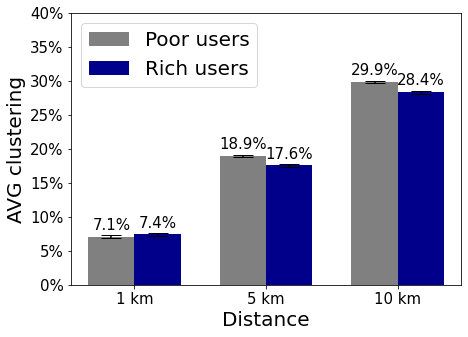

In [19]:
# parameters of chart
fig, ax = plt.subplots(1,1, figsize=(7, 5))

titles = ['1 km', '5 km', '10 km']

# colors of bars
colorsList = ["grey", "darkblue"]

# bar plot creation
X = np.arange(3)
bar_width = 0.35
rects1 = ax.bar(X, cluster_plot[0:3]['mean'], color = colorsList[0], width = bar_width, label = 'Poor users',
    yerr = [cluster_plot[0:3]['error_lower'], cluster_plot[0:3]['error_upper']], capsize = 10)
rects2 = ax.bar(X + bar_width, cluster_plot[3:]['mean'], color = colorsList[1], width = bar_width, label = 'Rich users',
    yerr = [cluster_plot[3:]['error_lower'], cluster_plot[3:]['error_upper']], capsize = 10) 

# customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels=['Poor users', 'Rich users'], fontsize = 20, loc="upper left")
ax.set(ylabel='AVG clustering')
ax.set(xlabel='Distance')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0)) 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticks(X + bar_width/2)
ax.set_xticklabels(['1 km', '5 km', '10 km'])
ax.set_ylim([0, 0.4])

# function used for labelling
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate("{:.1%}".format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 15)
autolabel(rects1)
autolabel(rects2)

#plt.tight_layout()
plt.savefig('../fig/fig5.png',density=300,bbox_inches='tight')
#plt.show()

## supported ties around HOME

In [20]:
# clustering table
supp_table = pd.read_csv("../data/supp_tab_top50.csv.gz")

# poor / rich info
user_info = pd.read_csv("../data/degree_tab_top50.csv.gz")
user_info = user_info[["user_id", "cbsacode", "short_name", "poor"]]

In [21]:
# add poor / rich info
supp_table = pd.merge(supp_table, user_info, on="user_id", how="left")

In [22]:
# create poor / rich groups
supp_rich = supp_table[supp_table['poor'] == 0]
supp_poor = supp_table[supp_table['poor'] == 1]

In [23]:
# bootstrap function
def draw_bs_replicates(data, func, size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # create an empty array to store replicates
    bs_replicates = np.empty(size)
    np.random.seed(30)
    # create bootstrap replicates as much as size
    for i in range(size):
        # create a bootstrap sample
        bs_sample = np.random.choice(data, size=len(data))
        # get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

In [24]:
# construct a dataframe -poor- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# type plot
type = ["poor"] * 3

# name the necessary columns
col_filter = ['support1000','support5000', 'support10000']

# table and columns to use
temp = supp_poor.loc[:, supp_poor.columns.isin(col_filter)]

# loop for variables
for c in list(temp.columns):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)].dropna(), np.mean, 2000)   # change repetition HERE
    means.append(np.mean(bootstrap_mean))
    lower.append(np.percentile(bootstrap_mean, 2.5))
    upper.append(np.percentile(bootstrap_mean, 97.5))
    error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
    error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_poor = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type})

In [25]:
# construct a dataframe -rich- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# type plot
type = ["rich"] * 3

# name the necessary columns
col_filter = ['support1000','support5000', 'support10000']

# table and columns to use
temp = supp_rich.loc[:, supp_rich.columns.isin(col_filter)]

# loop for variables
for c in list(temp.columns):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)].dropna(), np.mean, 2000)   # change repetition HERE
    means.append(np.mean(bootstrap_mean))
    lower.append(np.percentile(bootstrap_mean, 2.5))
    upper.append(np.percentile(bootstrap_mean, 97.5))
    error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
    error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_rich = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type})

In [26]:
# combine
support_plot = pd.concat([result_poor, result_rich])

<ipython-input-36-a29db8406416>:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/fig6.png',density=300,bbox_inches='tight')


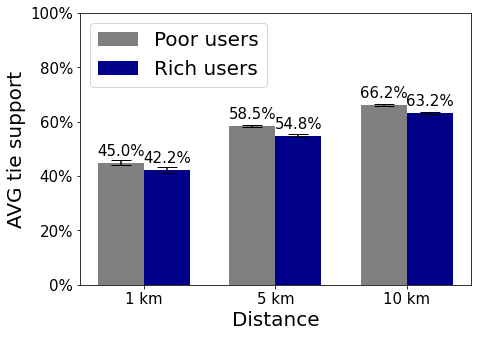

In [36]:
# parameters of chart
fig, ax = plt.subplots(1,1, figsize=(7, 5))

titles = ['1 km', '5 km', '10 km']

# colors of bars
colorsList = ["grey", "darkblue"]

# bar plot creation
X = np.arange(3)
bar_width = 0.35
rects1 = ax.bar(X, support_plot[0:3]['mean'], color = colorsList[0], width = bar_width, label = 'Poor users',
    yerr = [support_plot[0:3]['error_lower'], support_plot[0:3]['error_upper']], capsize = 10)

rects2 = ax.bar(X + bar_width, support_plot[3:]['mean'], color = colorsList[1], width = bar_width, label = 'Rich users',
    yerr = [support_plot[3:]['error_lower'], support_plot[3:]['error_upper']], capsize = 10) 

# customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels=['Poor users', 'Rich users'], fontsize = 20, loc="upper left")
ax.set(ylabel='AVG tie support')
ax.set(xlabel='Distance')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0)) 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticks(X + bar_width/2)
ax.set_xticklabels(['1 km', '5 km', '10 km'])
ax.set_ylim([0, 1])

# function used for labelling
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate("{:.1%}".format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 15)
autolabel(rects1)
autolabel(rects2)

#plt.tight_layout()
#plt.savefig('../figures/clustering_home_inc.jpg')
plt.savefig('../fig/fig6.png',density=300,bbox_inches='tight')
#plt.show()